In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import KElbowVisualizer
from numpy import math
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

<ipython-input-1-e91b8758e284>:11: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  from numpy import math


#Loading and Reading dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#url="https://view.officeapps.live.com/op/view.aspx?src=https%3A%2F%2Fgitfront.io%2Fr%2Fuser-9324447%2FW4ee46hfqoew%2FPersonal-Projects%2Fraw%2FCustomer%2520Segmentation%2520%2528RFM%2520analystic%2529%2Fdata.xlsx&wdOrigin=BROWSELINK"
data = pd.read_excel('/content/drive/MyDrive/dataset/data.xlsx')
print("-"*50)
print("Dữ liệu được nhập thành công!!")
data.head(3).style.set_properties(**{"background-color": "#cd5c5c","color": "black", "border-color": "black"})


--------------------------------------------------
Dữ liệu được nhập thành công!!


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.550000,17850.000000,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.390000,17850.000000,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.750000,17850.000000,United Kingdom


#Exploring Information of the dataset

In [ ]:
pd.set_option('display.max_columns',None)

In [ ]:
def data_overview(df,head=5):
  print("shape of dataset ".center(125,'-'))
  print('Rows:{}'.format(df.shape[0]))
  print('columns:{}'.format(df.shape[1]))
  print("Head ".center(125,'-'))
  print(df.head(head))
  print("Data types".center(125,'-'))
  print(data.dtypes.value_counts())
  print("Missing values ".center(125,'-'))
  print(df.isnull().sum()[df.isnull().sum()>0].sort_values(ascending=False))
  print("Duplicate values ".center(125,'-'))
  print(df.duplicated().sum())
  print("Statistics os data ".center(125,'-'))
  print(df.describe(include="all"))
  print("Data info".center(125,'-'))
  print(df.info())

data_overview(data)

------------------------------------------------------shape of dataset ------------------------------------------------------
Rows:541909
columns:8
------------------------------------------------------------Head ------------------------------------------------------------
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     1785

- Bộ dữ liệu có Hàng: 1067371 và Cột: 8.

- Dataset có 3 loại cột: strings(5), số nguyên(1), float(2).

- Tập dữ liệu bị thiếu giá trị trong ID khách hàng (243007) và Mô tả (4382).

- Hóa đơn bắt đầu bằng chữ 'c' cần được làm sạch vì giao dịch bị hủy.

- Bộ dữ liệu có dữ liệu trùng lặp.

- Đồng thời kiểm tra giá trị âm và các ngoại lệ về Số lượng và Giá cả.

#Data Wrangling

1. xử lý giá trị còn thiếu

In [ ]:
print("Hình dạng dữ liệu trước khi xóa CustomerID của NaN",data.shape)
data.dropna(subset="CustomerID",axis=0,inplace=True)
print("Hình dạng dữ liệu sau khi xóa CustomerID của NaN",data.shape)

Hình dạng dữ liệu trước khi xóa CustomerID của NaN (541909, 8)
Hình dạng dữ liệu sau khi xóa CustomerID của NaN (406829, 8)


In [ ]:
print("Thiếu giá trị trong mỗi cột sau khi xóa ID khách hàng:\n",data.isnull().sum())

Thiếu giá trị trong mỗi cột sau khi xóa ID khách hàng:
 InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64


2. Xóa sản phẩm bị hủy khỏi hóa đơn

In [ ]:
data = data[~data.InvoiceNo.str.contains('C',na=False)]
print("Bộ dữ liệu không có thông tin sản phẩm bị hủy")

Bộ dữ liệu không có thông tin sản phẩm bị hủy


3. Xóa giá trị trùng lặp

In [ ]:
print("Số lượng bản sao trước khi làm sạch:",data.duplicated().sum())
data = data.drop_duplicates(keep="first")
print("Số lượng bản sao sau khi làm sạch:",data.duplicated().sum())

Số lượng bản sao trước khi làm sạch: 5192
Số lượng bản sao sau khi làm sạch: 0


4. Kiểm tra giá trị âm

In [ ]:
print("Giá trị âm trong Số lượng là:",(data.Quantity<0).sum())
print("Giá trị âm trong Giá là:",(data.UnitPrice<0).sum())

Giá trị âm trong Số lượng là: 0
Giá trị âm trong Giá là: 0


#**EDA: Feature Engineering**

In [ ]:
#Tạo tính năng mới Doanh thu
data["Revenue"] = data["Quantity"] * data["UnitPrice"]

In [ ]:
#Thay đổi kiểu dữ liệu thành datetime
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

In [ ]:
print("Max date :",data["InvoiceDate"].max())
print("Min date :",data["InvoiceDate"].min())

Max date : 2011-12-09 12:50:00
Min date : 2010-12-01 08:26:00


In [ ]:
#Đặt ngày muộn nhất 2011-12-10 làm ngày hóa đơn cuối cùng là 2011-12-09.
Latest_Date = dt.datetime(2011,12,10)

#Tạo các tính năng RFM với tập hợp con ID khách hàng
RFM = data.groupby('CustomerID').agg({'InvoiceDate': lambda x: (Latest_Date - x.max()).days,
                                                 'InvoiceNo': lambda x: x.nunique(),
                                                 "Revenue": lambda x: x.sum()})

RFM['InvoiceDate'] = RFM['InvoiceDate'].astype(int)

#Đổi tên các tên cột thành Lần gần đây, Tần suất và Tiền tệ
RFM.rename(columns={'InvoiceDate': 'Recency',
                         'InvoiceNo': 'Frequency',
                         'Revenue': 'Monetary'}, inplace=True)

RFM.reset_index().head().style.set_properties(**{"background-color": "#cd5c5c","color": "black", "border-color": "black"})

,CustomerID,Recency,Frequency,Monetary
0,12346.000000,325,1,77183.600000
1,12347.000000,2,7,4310.000000
2,12348.000000,75,4,1797.240000
3,12349.000000,18,1,1757.550000
4,12350.000000,310,1,334.400000


In [ ]:
RFM = RFM[(RFM["Frequency"]>1)]
RFM.head().style.set_properties(**{"background-color": "#cd5c5c","color": "black", "border-color": "black"})

,Recency,Frequency,Monetary
CustomerID,,,
12347.000000,2,7,4310.000000
12348.000000,75,4,1797.240000
12352.000000,36,8,2506.040000
12356.000000,22,3,2811.430000
12358.000000,1,2,1168.060000


In [ ]:
Shopping_Cycle = data.groupby('CustomerID').agg({'InvoiceDate': lambda x: ((x.max() - x.min()).days)})

In [ ]:
RFM["Shopping_Cycle"] = Shopping_Cycle
RFM.head().style.set_properties(**{"background-color": "#cd5c5c","color": "black", "border-color": "black"})

,Recency,Frequency,Monetary,Shopping_Cycle
CustomerID,,,,
12347.000000,2,7,4310.000000,365
12348.000000,75,4,1797.240000,282
12352.000000,36,8,2506.040000,260
12356.000000,22,3,2811.430000,302
12358.000000,1,2,1168.060000,149


In [ ]:
RFM["Interpurchase_Time"] = RFM["Shopping_Cycle"] // RFM["Frequency"]
RFMT = RFM[["Recency","Frequency","Monetary","Interpurchase_Time"]]
RFMT.head().style.set_properties(**{"background-color": "#cd5c5c","color": "black", "border-color": "black"})

,Recency,Frequency,Monetary,Interpurchase_Time
CustomerID,,,,
12347.000000,2,7,4310.000000,52
12348.000000,75,4,1797.240000,70
12352.000000,36,8,2506.040000,32
12356.000000,22,3,2811.430000,100
12358.000000,1,2,1168.060000,74


#**Modeling with Kmeans Algorithm**

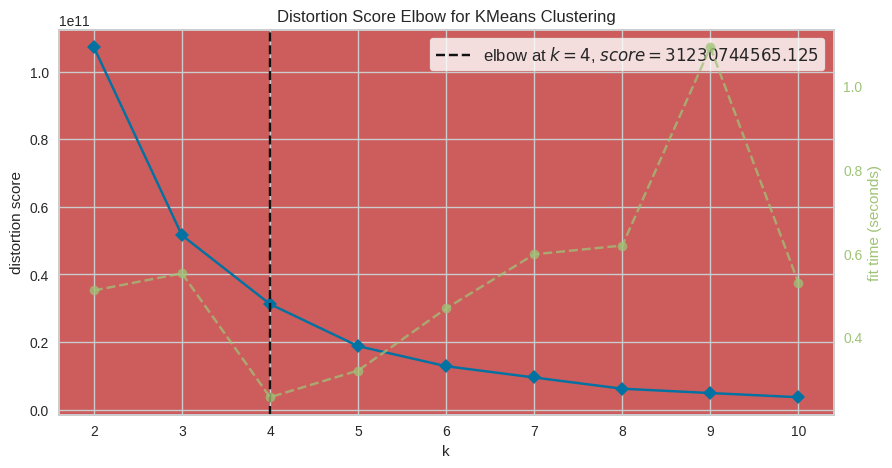

Therefore K = 4


In [ ]:
# Tìm giá trị K bằng phương pháp Elbow
plt.figure(figsize=(10,5))
ax = plt.axes()
ax.set_facecolor("#cd5c5c")
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(RFMT)
Elbow_M.show()
print("Therefore K = 4")

In [ ]:
kmeans = KMeans(n_clusters=4,max_iter=50)
kmeans.fit(RFMT)

KMeans(max_iter=50, n_clusters=4)

In [ ]:
RFMT["Clusters"]=kmeans.labels_
RFMT.head().style.set_properties(**{"background-color": "#cd5c5c","color": "black", "border-color": "black"})

,Recency,Frequency,Monetary,Interpurchase_Time,Clusters
CustomerID,,,,,
12347.000000,2,7,4310.000000,52,0
12348.000000,75,4,1797.240000,70,0
12352.000000,36,8,2506.040000,32,0
12356.000000,22,3,2811.430000,100,0
12358.000000,1,2,1168.060000,74,0


#**Model : Evaluation**

In [ ]:
kmeans.cluster_centers_

array([[5.89245014e+01, 5.43340456e+00, 2.00326506e+03, 4.64754274e+01],
       [8.40000000e+00, 6.50000000e+01, 1.49739814e+05, 2.60000000e+01],
       [2.02000000e+01, 4.42000000e+01, 4.53162887e+04, 1.13666667e+01],
       [5.00000000e-01, 6.70000000e+01, 2.69931660e+05, 5.00000000e+00]])

<function matplotlib.pyplot.show(close=None, block=None)>

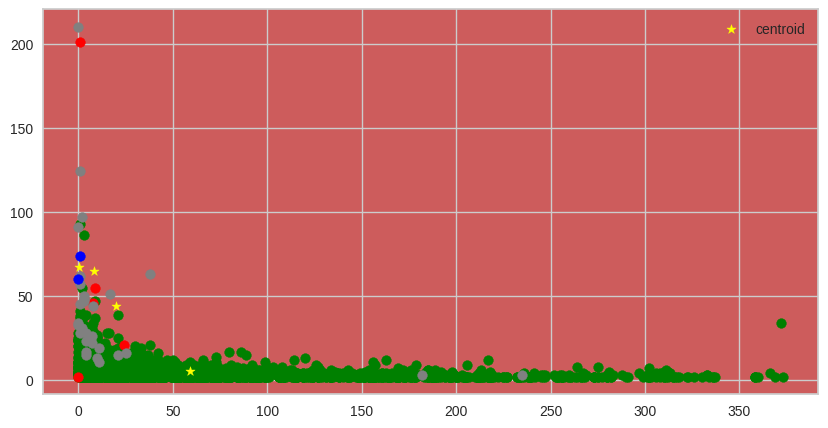

In [ ]:
# nhóm dữ liệu theo từng cụm riêng biệt
one = RFMT[RFMT["Clusters"]==0]
two = RFMT[RFMT["Clusters"]==1]
three = RFMT[RFMT["Clusters"]==2]
four = RFMT[RFMT["Clusters"]==3]

#Kiểm tra chất lượng phân cụm trong tập dữ liệu
plt.figure(figsize=(10,5))
ax = plt.axes()
ax.set_facecolor("#cd5c5c")
plt.scatter(one["Recency"],one["Frequency"],color='green')
plt.scatter(two["Recency"],two["Frequency"],color='red')
plt.scatter(three["Recency"],three["Frequency"],color='grey')
plt.scatter(four["Recency"],four["Frequency"],color='blue')

plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],color="yellow",marker="*",label="centroid")
plt.legend()
plt.show

In [ ]:
RFMT.groupby('Clusters').agg({
    'Recency': ['mean','min','max'],
    'Frequency': ['mean','min','max'],
    'Monetary': ['mean','min','max']
    ,'Interpurchase_Time': ['mean','min','max']
}).round(2).style.set_properties(**{"background-color": "#cd5c5c","color": "black", "border-color": "black"})



In [ ]:
RFMT.groupby('Clusters').size().reset_index(name = 'Count').style.set_properties(**{"background-color": "#cd5c5c","color": "black", "border-color": "black"})

,Clusters,Count
0,0,2808
1,1,5
2,2,30
3,3,2


In [ ]:
## Đăc điểm trung bình của các nhóm
RFMT.groupby('Clusters').mean().style.set_properties(**{"background-color": "#cd5c5c","color": "black", "border-color": "black"})

,Recency,Frequency,Monetary,Interpurchase_Time
Clusters,,,,
0,58.924501,5.433405,2003.265058,46.475427
1,8.400000,65.000000,149739.814000,26.000000
2,20.200000,44.200000,45316.288667,11.366667
3,0.500000,67.000000,269931.660000,5.000000


In [ ]:
mapping = {0: 'Need attention', 1: ' Champions', 2: 'Potential Loyalist', 3: 'Promising'}

RFMT['segment'] = RFMT['Clusters'].map(mapping)


In [ ]:
RFMT.head().style.set_properties(**{"background-color": "#cd5c5c","color": "black", "border-color": "black"})

,Recency,Frequency,Monetary,Interpurchase_Time,Clusters,segment
CustomerID,,,,,,
12347.000000,2,7,4310.000000,52,0,Need attention
12348.000000,75,4,1797.240000,70,0,Need attention
12352.000000,36,8,2506.040000,32,0,Need attention
12356.000000,22,3,2811.430000,100,0,Need attention
12358.000000,1,2,1168.060000,74,0,Need attention


In [ ]:
RFMT.columns

Index(['Recency', 'Frequency', 'Monetary', 'Interpurchase_Time', 'Clusters',
       'segment'],
      dtype='object')

In [ ]:
!pip install squarify


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 7875 (\N{LATIN SMALL LETTER E WITH CIRCUMFLEX AND HOOK ABOVE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 7891 (\N{LATIN SMALL LETTER O WITH CIRCUMFLEX AND GRAVE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


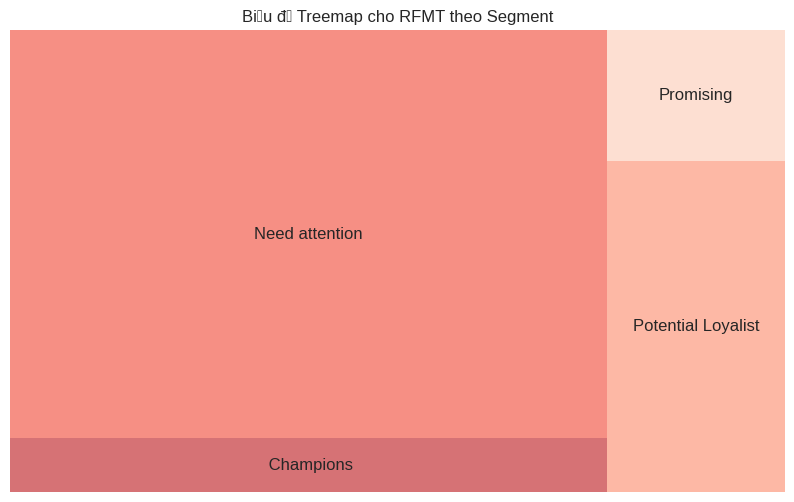

In [ ]:
import squarify
# Nhóm dữ liệu theo 'segment'
grouped_df = RFMT.groupby('segment')['Monetary'].sum().reset_index()

# Tạo một biểu đồ treemap
plt.figure(figsize=(10, 6))
colors = sns.color_palette("Reds_r", n_colors=4)
squarify.plot(sizes=grouped_df['Monetary'], label=grouped_df['segment'], alpha=0.6, color=colors)

# Đặt tiêu đề
plt.title("Biểu đồ Treemap cho RFMT theo Segment")

# Hiển thị biểu đồ
plt.axis('off')
plt.show()

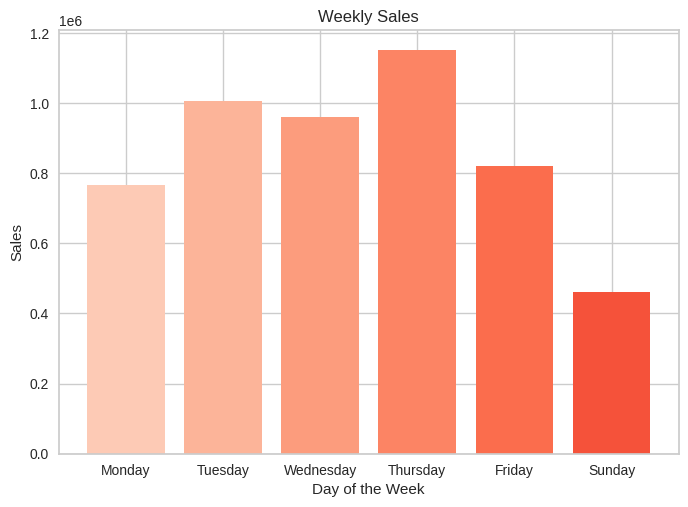

In [ ]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
data['Weekday'] = data['InvoiceDate'].dt.dayofweek
weekday_sales = data.groupby('Weekday').agg({'Quantity': 'sum'})

# trực quan doanh thu theo tuần sử dụng biểu đồ cột đứng
colors = plt.cm.Reds(np.linspace(0.2, 1, len(monthly_sales)))
fig, ax = plt.subplots()
ax.bar(range(6), weekday_sales['Quantity'], color=colors)
ax.set_xlabel('Day of the Week')
ax.set_ylabel('Sales')
ax.set_title('Weekly Sales')
ax.set_xticks(range(6))
ax.set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Sunday'])

plt.show()


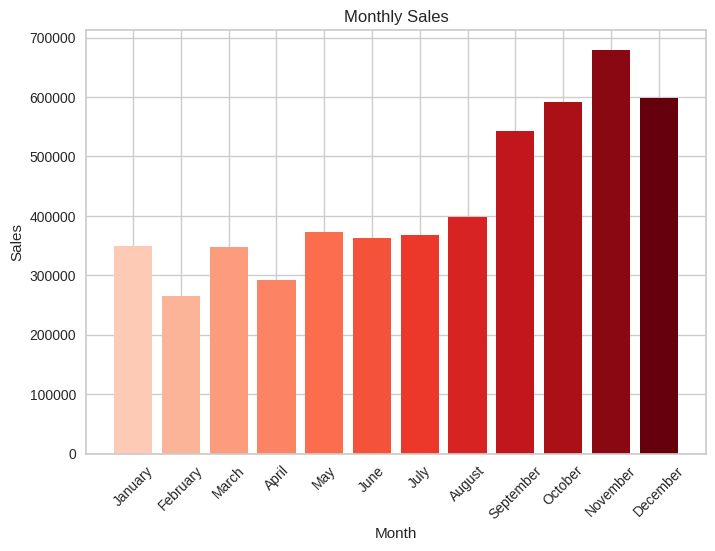

In [ ]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
data['Month'] = data['InvoiceDate'].dt.month
monthly_sales = data.groupby('Month').agg({'Quantity': 'sum'})

# Trực quan doanh thu theo tháng sử dụng biểu đồ cột đứng.
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# Tạo một gradient màu đỏ từ nhạt đến đậm
colors = plt.cm.Reds(np.linspace(0.2, 1, len(monthly_sales)))

fig, ax = plt.subplots()
ax.bar(monthly_sales.index, monthly_sales['Quantity'], color=colors)
ax.set_xlabel('Month')
ax.set_ylabel('Sales')
ax.set_title('Monthly Sales')
ax.set_xticks(monthly_sales.index)
ax.set_xticklabels(months, rotation=45)
plt.xticks(monthly_sales.index, months)
plt.show()

In [ ]:
data['Revenue'] = data.groupby('InvoiceNo')['Quantity'].transform(lambda x: x * data.groupby('InvoiceNo')['UnitPrice'].transform('sum'))
data['Revenue']

0         164.22
1         164.22
2         218.96
3         164.22
4         164.22
           ...  
541904    534.00
541905    267.00
541906    178.00
541907    178.00
541908    133.50
Name: Revenue, Length: 392732, dtype: float64

Silhouette Coefficient or silhouette score  là số liệu được sử dụng để tính toán mức độ tốt của kỹ thuật phân cụm. Giá trị của nó nằm trong khoảng từ -1 đến 1. Điểm càng gần 1 thì cụm được phân biệt càng cao

In [ ]:
from sklearn.metrics import silhouette_score

# Loại bỏ cột 'segment' từ bảng RFMT
RFMT_without_segment = RFMT.drop(columns=['segment'])

# Tính silhouette score
silhouette_score_value = silhouette_score(RFMT_without_segment, kmeans.labels_, metric='euclidean')
print("Silhouette score:", silhouette_score_value)

Silhouette score: 0.9414009464343936


In [ ]:

merged_data = pd.merge(data, RFMT, on='CustomerID', how='inner')

merged_data.head(3).style.set_properties(**{"background-color": "#cd5c5c","color": "black", "border-color": "black"})


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue,Recency,Frequency,Monetary,Interpurchase_Time,Clusters,segment
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.550000,17850.000000,United Kingdom,15.300000,372,34,5391.210000,0,0,Hibernating Customer
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.390000,17850.000000,United Kingdom,20.340000,372,34,5391.210000,0,0,Hibernating Customer
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.750000,17850.000000,United Kingdom,22.000000,372,34,5391.210000,0,0,Hibernating Customer
